In [1]:
import pandas as pd

In [2]:
# company data by sector from insee, excessive data removed from 
# original to reduce size
# source :
# https://www.insee.fr/fr/statistiques/6524225?sommaire=5347729#consulter-sommaire

df = pd.read_csv('data/external/ree_def_2020.csv', sep=';')

In [3]:
# need mapping to convert from naf5 to naf2, 
# mapping provided sucks, download new one
# source:
# https://www.data.gouv.fr/fr/datasets/nomenclature-dactivites-francaise-naf/#resources
mapping = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/7bb2184b-88cb-4c6c-a408-5a0081816dcd', sep=',')

# statistics above have no in-line sepators - remove from mapping
mapping['id_5'] = mapping['id_5'].str.replace('.','')

# create series to merge
#naf5_naf2_naf1 = mapping.set_index('')[['id_2', 'id_1']]
df = df.merge(
    mapping[['id_1', 'id_2', 'id_5']],
    left_on='naf5', right_on='id_5',
    how='outer')

# check if decently merged
print(df.isna().sum())

# missing stats for :
# naf5  label
# 0520Z Extraction de lignite
# 9700Z Activités des ménages en tant qu'employeurs de personnel domestique
# 9810Z Activités indifférenciées des ménages en tant que producteurs de biens pour usage propre
# 9820Z Activités indifférenciées des ménages en tant que producteurs de services pour usage propre
# 9900Z Activités des organisations et organismes extraterritoriaux
#
# googling implies that less 10 000 in France go by under these naf:s,
# essentially a rounding error

df.dropna(inplace=True)

/var/folders/cz/nm0sr8dn1vd806c3239_r7k00000gn/T/ipykernel_12314/3602683860.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mapping['id_5'] = mapping['id_5'].str.replace('.','')


Unnamed: 0    5
naf5          5
size          5
count         5
id_1          0
id_2          0
id_5          0
dtype: int64


In [4]:
# Compute size of companies in terms of employees with
# theory that:
# more employees -> more likely to be in media

# size variable is categorical as following :
sizes = """
00 - 0 salarié
01 - 1 à 2 salariés
02 - 3 à 5 salariés
03 - 6 à 9 salariés
11 - 10 à 19 salariés
12 - 20 à 49 salariés
21 - 50 à 99 salariés
22 - 100 à 199 salariés
31 - 200 à 249 salariés
32 - 250 à 499 salariés
41 - 500 à 999 salariés
42 - 1 000 à 1 999 salariés
51 - 2 000 à 4 999 salariés
52 - 5 000 à 9 999 salariés
53 - 10 000 salariés et plus
"""
# the last variable goes to +inf but set

# will assume that companies lie in the
# middle of these ranges and 2000 for code 53
sizes = [int(i[:2]) for i in sizes.splitlines()[1:]]
employees = [
    0, 1.5, 4, 7.5, 14.5, 34.5,
    74.5, 149.5, 224.5, 374.5, 749.5,
    1499.5, 3499.5, 7499.5, 20000]
sizes = pd.Series({int(i): j for i, j in zip(sizes, employees)}).rename('employees_p_company')

df = df.merge(sizes, left_on='size', right_index=True)

df['employees'] = df['count'] * df['employees_p_company']
df['employees'].sum()

# gives a total of 26.7 million employees, insee says that
# there were 28.5 employed persons employed in France in 2020
# -> good enough

26685885.5

In [5]:
# agregation of companies by sheer number (count), 
# number of companies with >= 1 employees (count_active) and 
# by number of employees (size)

count = df.groupby('id_2')['count'].sum()
count_active = df.loc[df['size']!=0].groupby('id_2')['count'].sum().rename('active')
size = df.groupby('id_2')['employees'].sum()

# normalize and put into single df
aggregated = pd.concat([s / s.sum() for s in [count, count_active, size]], axis=1)
aggregated.index.rename('naf2', inplace=True)
aggregated.to_csv('data/priors.csv')


<AxesSubplot:xlabel='naf2'>

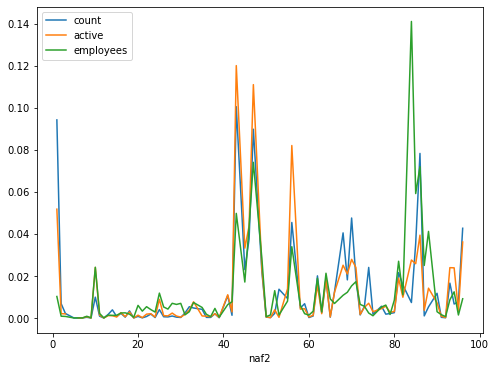

In [6]:
aggregated.plot(figsize=(8,6))